[Start with Google Colab](https://colab.research.google.com/github/seungjin-yang/bayesian-deep-learning/blob/master/examples/notebooks/Anomaly-Detection-via-VAEs.ipynb)

based on [TFP Probabilistic Layers VAE](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb)

In [1]:
try:
    import google.colab
    IS_COLAB = True
except:
    IS_COLAB = False

if IS_COLAB:
    ! pip install tensorflow-gpu==2.0.0
    ! pip install tensorflow-probability==0.8.0
    ! pip install tensorflow-datasets==1.2.0 
    ! pip install git+https://github.com/seungjin-yang/bayesian-deep-learning

  Cloning https://github.com/seungjin-yang/bayesian-deep-learning to /tmp/pip-req-build-x3chavcz
  Running command git clone -q https://github.com/seungjin-yang/bayesian-deep-learning /tmp/pip-req-build-x3chavcz
  Created wheel for extended-tfp: filename=extended_tfp-0.0.1-cp36-none-any.whl size=5356 sha256=cc4af04495e6830cbbc15f8287a3652d3b0503e4ccc4247cf06cb0b09071942f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8x4pn41p/wheels/64/bb/35/da8f0123198790598d839e1493c025353c4ba516b876cd55d3
Successfully built extended-tfp


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

import extended_tfp as extfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

tf.keras.backend.set_image_data_format('channels_first')

In [10]:
print(f'TensorFlow: {tf.version.VERSION}')
print(f'TensorFlow Probbility: {tfp.__version__}')
print(f'TensoroFlow Datasets: {tfds.__version__}')

TensorFlow: 2.0.0
TensorFlow Probbility: 0.8.0
TensoroFlow Datasets: 1.2.0


# Data

In [11]:
datasets, datasets_info = tfds.load(name='mnist', with_info=True, as_supervised=False)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


In [0]:
def preprocess_mnist(sample):
    # Scale to unit interval.
    image = tf.cast(sample['image'], tf.float32) / 255.
    # NHWC to NCHW
    image = tf.transpose(image, (2, 0, 1))
    
    # Randomly binarize.
    # image = image < tf.random.uniform(tf.shape(image))
    
    input_image = tf.cast(image, tf.float32)
    label_image = tf.cast(image, tf.int64)
    return input_image, image


train_dataset = (datasets['train']
                 .map(preprocess_mnist)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

eval_dataset = (datasets['test']
                .map(preprocess_mnist)
                .batch(256)
                .prefetch(tf.data.experimental.AUTOTUNE))

In [0]:
def build_model(input_shape, encoded_size=16, base_depth=32):
    prior = tfd.Independent(
        tfd.Normal(loc=tf.zeros(encoded_size), scale=1),
        reinterpreted_batch_ndims=1)

    # posterior
    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=input_shape),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=tf.nn.leaky_relu),
        # tfkl.Flatten(),
        tfkl.GlobalAveragePooling2D(),
        tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
                   activation=None),
        tfpl.MultivariateNormalTriL(
            encoded_size,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
    ])
    
    # likelihood
    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=[encoded_size]),
        tfkl.Reshape([encoded_size, 1, 1]),
        tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1,
                             padding='valid', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=2,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2DTranspose(base_depth, 5, strides=1,
                             padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(filters=1, kernel_size=5, strides=1,
                    padding='same', activation=None),
        tfkl.Flatten(),
        tfpl.IndependentBernoulli(
            event_shape=input_shape,
            convert_to_tensor_fn=tfd.Bernoulli.logits),
    ])
    
    vae = tfk.Model(
        inputs=encoder.inputs,
        outputs=decoder(encoder.outputs[0]))
    
    return vae, encoder, decoder, prior

In [0]:
vae, encoder, decoder, prior = build_model(input_shape=train_dataset.output_shapes[0][1:])

In [15]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 28, 28)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 14, 14)        25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 14, 14)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 7, 7)          102464    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 1, 1)          200768    
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 152)               9

In [16]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 16, 1, 1)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 7, 7)          50240     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 7, 7)          102464    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 14, 14)        102464    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 14, 14)        51232     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 28, 28)        25632     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 28, 28)       

In [0]:
vae.compile(
    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
    loss=extfp.losses.negative_log_likelihood)

In [18]:
history = vae.fit(train_dataset, epochs=15, validation_data=eval_dataset)

Epoch 1/15
235/235 [==============================] - 48s 205ms/step - loss: 204.4584 - val_loss: 0.0000e+00
Epoch 2/15
235/235 [==============================] - 41s 174ms/step - loss: 150.0340 - val_loss: 140.0618
Epoch 3/15
235/235 [==============================] - 41s 175ms/step - loss: 138.2131 - val_loss: 134.4889
Epoch 4/15
235/235 [==============================] - 42s 177ms/step - loss: 133.0765 - val_loss: 130.2509
Epoch 5/15
235/235 [==============================] - 42s 178ms/step - loss: 129.5471 - val_loss: 126.8039
Epoch 6/15
235/235 [==============================] - 41s 176ms/step - loss: 127.0125 - val_loss: 125.7131
Epoch 7/15
235/235 [==============================] - 42s 177ms/step - loss: 125.0497 - val_loss: 124.2229
Epoch 8/15
235/235 [==============================] - 42s 177ms/step - loss: 123.3440 - val_loss: 121.7831
Epoch 9/15
235/235 [==============================] - 42s 177ms/step - loss: 121.8381 - val_loss: 120.9422
Epoch 10/15
235/235 [==============

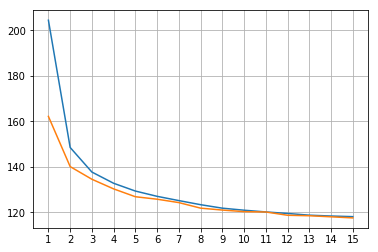

In [19]:
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss)
plt.plot(epoch, history.history['val_loss'])

_ = plt.xticks(epoch)
plt.grid()

# Visualize

In [0]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

In [0]:
def display_imgs(x, title=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    n = x.shape[0]
    fig, axarr = plt.subplots(1, n, figsize=(n, 1))
    
    if title is not None:
        fig.suptitle(title, y=1.05)
    
    for i in range(n):
        axarr.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axarr.flat[i].axis('off')

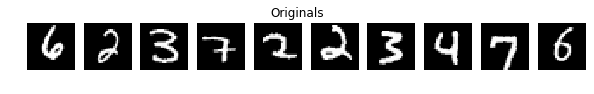

In [22]:
display_imgs(x, 'Originals')

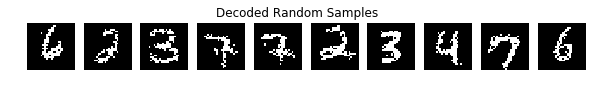

In [23]:
display_imgs(xhat.sample(), 'Decoded Random Samples')

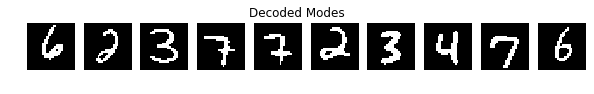

In [24]:
display_imgs(xhat.mode(), 'Decoded Modes')

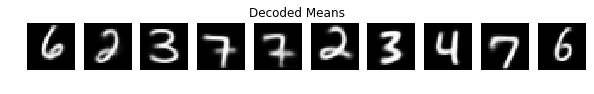

In [25]:
display_imgs(xhat.mean(), 'Decoded Means')

# Check mode collapse

# Anomalous Data

In [0]:
fashion_mnist = tfds.load('fashion_mnist', split='test')
emnist_letters = tfds.load('emnist/letters', split='test')

In [0]:
def preprocess_fashion_mnist(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.
    image = tf.transpose(image, (2, 0, 1))
    # image = image < tf.random.uniform(tf.shape(image))
    # image = tf.cast(image, tf.float32) - 0.5
    return image

In [0]:
def preprocess_emnist(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.
    image = tf.transpose(image, (2, 0, 1))
    image = tf.transpose(image, (0, 2, 1))
    # image = image < tf.random.uniform(tf.shape(image))
    # image = tf.cast(image, tf.float32) - 0.5
    return image

In [0]:
fashion_mnist = (fashion_mnist
                 .map(preprocess_fashion_mnist)
                 .batch(64)
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [0]:
emnist_letters = (emnist_letters
                .map(preprocess_emnist)
                .batch(64)
                .prefetch(tf.data.experimental.AUTOTUNE)
                .shuffle(int(1e3)))

In [0]:
def show_images(images, title=None, figsize=(4, 4)):
    if isinstance(images, tf.Tensor):
        images = images.numpy()
    images = images.squeeze()
    fig, axarr = plt.subplots(figsize=figsize, ncols=figsize[0], nrows=figsize[1])
    for ax, img in zip(axarr.flatten(), images):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.axis('off')
    if title is not None:
        fig.suptitle(title, y=1)

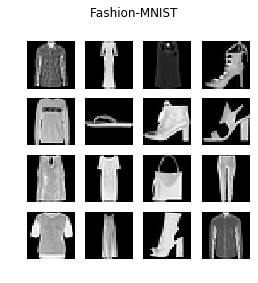

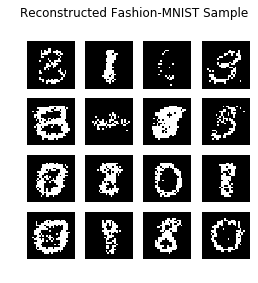

In [40]:
x_fashion = next(tfds.as_numpy(fashion_mnist))
x_fashion_dist = vae(x_fashion)

show_images(x_fashion, title='Fashion-MNIST')
show_images(x_fashion_dist.sample(), title='Reconstructed Fashion-MNIST Sample')

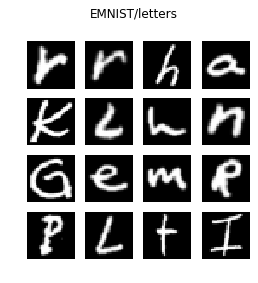

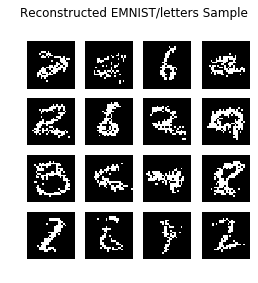

In [41]:
x_letters = next(tfds.as_numpy(emnist_letters))
x_letters_dist = vae(x_letters)

show_images(x_letters, title='EMNIST/letters')
show_images(x_letters_dist.sample(), title='Reconstructed EMNIST/letters Sample')

In [0]:
class GenerativeModel(tfk.Model):

    def __init__(self, prior, likelihood):
        super(GenerativeModel, self).__init__(name='generative_model')
        self.prior = prior
        self.likelihood = likelihood

    def call(self, inputs=None):
        return self.likelihood(self.prior.sample(1))

generative_model = GenerativeModel(prior, decoder)